In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from DiffractiX import Simulation
from DiffractiX.constants import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

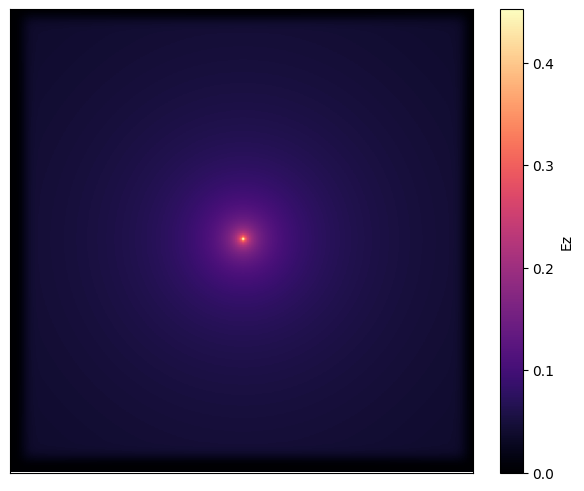

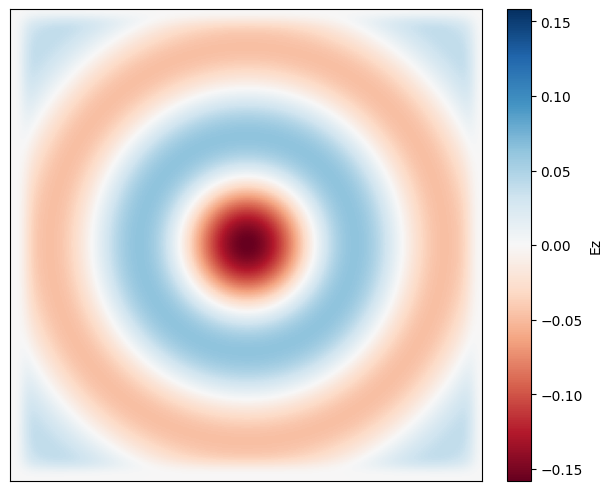

In [12]:
omega = 2*np.pi*200e12
dl = 0.02 # grid size (units of L0, which defaults to 1e-6)
eps_r = np.ones((200, 200)) # relative permittivity
NPML = [15, 15] # number of pml grid points on x and y borders

simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.src[100, 100] = 1
simulation.solve_fields()

simulation.plt_abs(outline=False, cbar=True)
simulation.plt_re(outline=False, cbar=True);

input power of 0.0016689051864977786 in W/L0


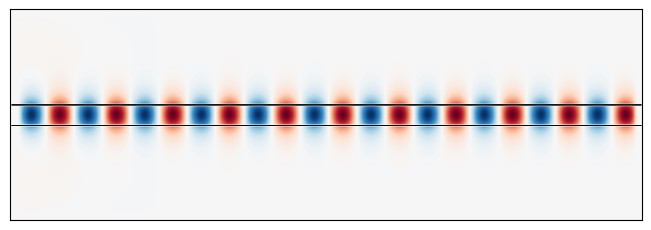

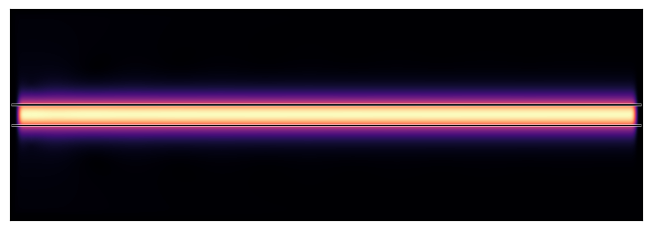

In [4]:
omega = 2*np.pi*200e12
dl = 0.01 # grid size (units of L0, which defaults to 1e-6)
eps_r = np.ones((600, 200)) # relative permittivity
eps_r[:,90:110] = 12.25 # set waveguide region
NPML = [15, 15] # number of pml grid points on x and y borders

simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [20, 100], 60, scale=10)
simulation.setup_modes()
simulation.solve_fields()
print('input power of {} in W/L0'.format(simulation.W_in))

simulation.plt_re(outline=True, cbar=False)
simulation.plt_abs(outline=True, cbar=False);

In [5]:
from IPython.display import HTML
from DiffractiX.plot import plt_base_ani
animation = plt_base_ani(simulation.fields["Ez"], cbar=False, Nframes=40, interval=80)

HTML(animation.to_jshtml())
# animation.save('fields.gif', dpi=300, writer='ffmpeg')

In [3]:
omega = 2*np.pi*200e12         # angular frequency (rad/sec)
dl = 0.01                      # grid size (microns)
Nx, Ny = 600, 200              # x and y grid size
eps_r = np.ones((Nx, Ny))    # relative permittivity
eps_m = 12.25                  # maximum relative permittivity (Si)
wg_width = 20                  # waveguide width in pixels
eps_r[:,Ny//2:Ny//2+wg_width] = eps_m        # define a waveguide

# define the region where nonlinearity will occur
nl_region = np.zeros(eps_r.shape)
nl_region[100:Nx-100, Ny//2:Ny//2+wg_width] = 1

linear power transmission of 0.999656216026699


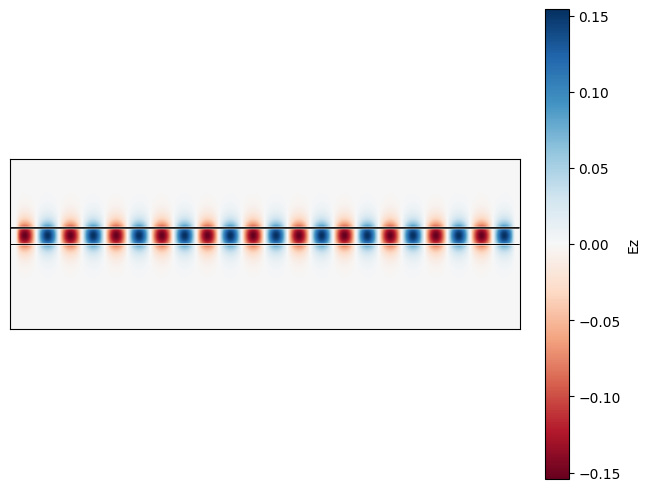

In [4]:
# make a new simulation
simulation = Simulation(omega, eps_r, dl, [15, 15], 'Ez')

# add a waveguide mode on the left side 
simulation.add_mode(np.sqrt(eps_m), 'x', [17, Ny//2], Ny-50)
simulation.setup_modes()

# solve the fields
simulation.solve_fields()
simulation.plt_re(outline=True)

# compute the transmission
fld0 = simulation.fields['Ez'][20, Ny//2]
fld1 = simulation.fields['Ez'][Nx-20, Ny//2]
T_linear = fld1/fld0
print('linear power transmission of {}'.format(np.square(np.abs(T_linear))))

In [8]:
# add nonlinearity into the system
chi3 = 2.8*1e-18
simulation.nonlinearity = []
simulation.add_nl(chi3, nl_region, eps_scale=False)

# modal source amplitudes to scan over
Ns = 10
srcval_vec = np.logspace(1, 3, Ns)
pwr_vec = np.array([])
T_vec = np.array([])

for i, srcval in enumerate(srcval_vec):
    print("solving {}/{} with source scaling of {}".format(i, Ns, srcval))

    # remove the source and make a new one with amplitude of srcval
    del simulation.modes[0]
    simulation.add_mode(np.sqrt(eps_m), 'x', [17, Ny//2], Ny-50, scale=srcval)
    simulation.setup_modes()

    # solve the nonlinear fields
    simulation.solve_fields_nl(solver_nl='newton')

    # compute the nonlinear transmission
    fld0 = simulation.fields_nl['Ez'][20, Ny//2]
    fld1 = simulation.fields_nl['Ez'][Nx-20, Ny//2]
    T_vec = np.append(T_vec, fld1/fld0)
    
    # compute the power transmission
    pwr = simulation.flux_probe('x', [Nx-20, Ny//2], Ny-50, nl=True)
    pwr_vec = np.append(pwr_vec, pwr)

solving 0/10 with source scaling of 10.0
solving 1/10 with source scaling of 16.68100537200059
solving 2/10 with source scaling of 27.825594022071243
solving 3/10 with source scaling of 46.41588833612777
solving 4/10 with source scaling of 77.4263682681127
solving 5/10 with source scaling of 129.1549665014884
solving 6/10 with source scaling of 215.44346900318823
solving 7/10 with source scaling of 359.38136638046257
solving 8/10 with source scaling of 599.4842503189409
solving 9/10 with source scaling of 1000.0


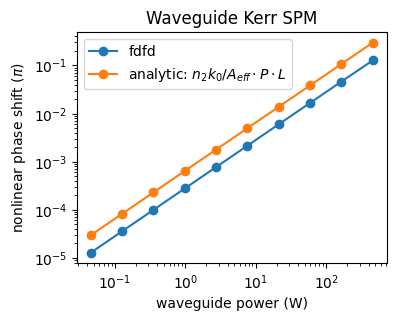

In [9]:
# compute the analytical form of the analytical phase shift from SPM

# get effective area
field_profile = simulation.fields['Ez'][Nx//2,:]
width_eff = np.square(np.sum(np.square(np.abs(field_profile)))) / np.sum(np.power(np.abs(field_profile), 4))
width = dl*width_eff
height = width*100
Aeff = width*height # Assume square wg if extrapolated to 3D

# get the analytical self phase
n2 = 3*chi3/simulation.L0/simulation.L0/(C_0/simulation.L0)/np.sqrt(eps_m)/(EPSILON_0*simulation.L0)
L = dl*(Nx-200)
gamma_spm = (omega/3e8*simulation.L0)*n2/Aeff

# plot the nonlinear phase shift vs power
plt.figure(figsize=(4,3))
plt.loglog(pwr_vec*height, -np.unwrap(np.angle(T_vec)-np.angle(T_linear))/np.pi, "-o", label="fdfd")
plt.loglog(pwr_vec*height, (pwr_vec*height)*L*gamma_spm/np.pi, "-o", label=r"analytic: $n_2k_0/A_{eff}\cdot P \cdot L$")
plt.xlabel("waveguide power (W)")
plt.ylabel("nonlinear phase shift ($\pi$)")
plt.title("Waveguide Kerr SPM")
plt.legend()
plt.show()